<a href="https://colab.research.google.com/github/herrayush/Delta_Onsite/blob/master/Final_Onsite_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import keras

x_data = np.linspace(-1, 1, num=100)
y_data = - np.tanh(10*x_data-3) - np.tanh(10*x_data+3)+ np.tanh(10*x_data-4) + np.tanh(10*x_data+4) + 0.0001*np.random.normal(size=100)

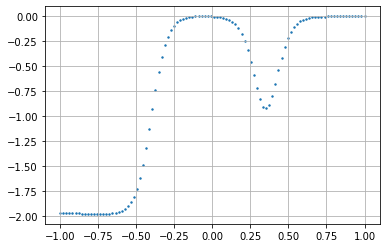

100


In [24]:
plt.scatter(x_data[::1], y_data[::1], s=2)
plt.grid()
plt.show()


print(len(x_data))

In [25]:
x_train = x_data[:len(x_data) - len(x_data)//2]
x_test = x_data[len(x_data) - len(x_data)//2:]
print(len(x_train),len(x_test))

y_train = y_data[:len(y_data) - len(y_data)//2]
y_test = y_data[len(y_data) - len(y_data)//2:]
print(len(x_train),len(x_test))

50 50
50 50


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


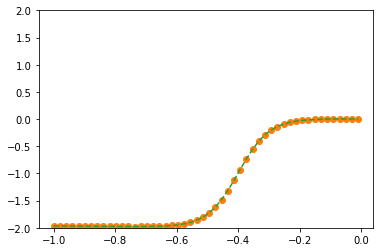

In [26]:
import warnings

z = np.polyfit(x_train, y_train, 100)

x = x_train
y = y_train
p = np.poly1d(z)
import matplotlib.pyplot as plt
with warnings.catch_warnings():
    warnings.simplefilter('ignore', np.RankWarning)
    p30 = np.poly1d(np.polyfit(x, y, 30))
xp = x_train
_ = plt.plot(x, y, '.', xp, p(xp), 'o', xp, p30(xp), '--')
plt.ylim(-2,2)

plt.show()

In [28]:
from sklearn.metrics import mean_squared_error 

mean_squared_error(y_test,p30(xp)) 


1.5333149429356616